### In this notebook, I try to add stellar mass and redshift into $\vec{\theta}$, plus noise into the data and forward models

try to write this notebook in a more streamline way

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, StandardScaler

In [131]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model_TZD.pkl', 'rb') as f:
    speculator = pickle.load(f)

speculator.params_name += ['logm', 'redshift']
speculator._build_params_prior()
speculator.bounds = np.array([speculator.prior[key] for key in speculator.params_name])
# speculator.network.eval();

noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [132]:
speculator.bounds

array([[ 0, 14],
       [-4,  4],
       [-3,  2],
       [ 0,  5],
       [ 0, 16],
       [ 0, 10]])

['tage', 'logtau', 'logzsol', 'dust2', 'log M*', 'redshift']

In [5]:
def gen_truth(sfh_kwargs, logz_logm_kwargs, 
              dust2_kwargs, redshift_kwargs, 
              nsamples=5000, random_state=None):
    if random_state is not None:
        torch.manual_seed(random_state)
    y_sfh = MultivariateNormal(torch.Tensor(sfh_kwargs['loc']), 
                               covariance_matrix=torch.Tensor(sfh_kwargs['cov'])
                              ).sample(sample_shape=(nsamples,))
    
    y_logz_logm = MultivariateNormal(torch.Tensor(logz_logm_kwargs['loc']), 
                                     torch.Tensor(logz_logm_kwargs['cov'])
                                    ).sample(sample_shape=(nsamples // 2,))
    y_logz_logm = torch.vstack([y_logz_logm, MultivariateNormal(torch.Tensor([-0.5, 8.5]), 
                             torch.Tensor(logz_logm_kwargs['cov']) * 0.5,
                            ).sample(sample_shape=(nsamples // 2,))])

    y_dust2 = torch.normal(mean=dust2_kwargs['mean'], std=dust2_kwargs['std'], size=(nsamples, 1))
    y_redshift = torch.normal(mean=redshift_kwargs['mean'], std=redshift_kwargs['std'], size=(nsamples, 1))
    
    Y_truth = torch.hstack([y_sfh, y_logz_logm[:, 0:1], y_dust2, y_logz_logm[:, 1:], y_redshift]).to('cuda')
    return Y_truth

In [6]:
sfh_kwargs = {'loc': [6, 0], 'cov': [[1, 0], [0, 0.3]]}
logz_logm_kwargs = {'loc': [-0.5, 10.5], 
                    'cov': [[0.3, 0.2], 
                            [0.4, 0.6]]}
dust2_kwargs = {'mean': 1, 'std': 0.5}
redshift_kwargs = {'mean': 0.15, 'std': 0.03}

In [7]:
Y_truth = gen_truth(sfh_kwargs, logz_logm_kwargs, 
                    dust2_kwargs, redshift_kwargs,
                    nsamples=5000, random_state=None)

In [8]:
filters = ['sdss_{0}0'.format(b) for b in 'ugriz']
# filters = ['hsc_{0}'.format(b) for b in 'grizy']
# filters = ['galex_NUV'] + ['hsc_{0}'.format(b) for b in 'grizy'] + ['jwst_f090w', 'jwst_f115w', 'jwst_f140m']

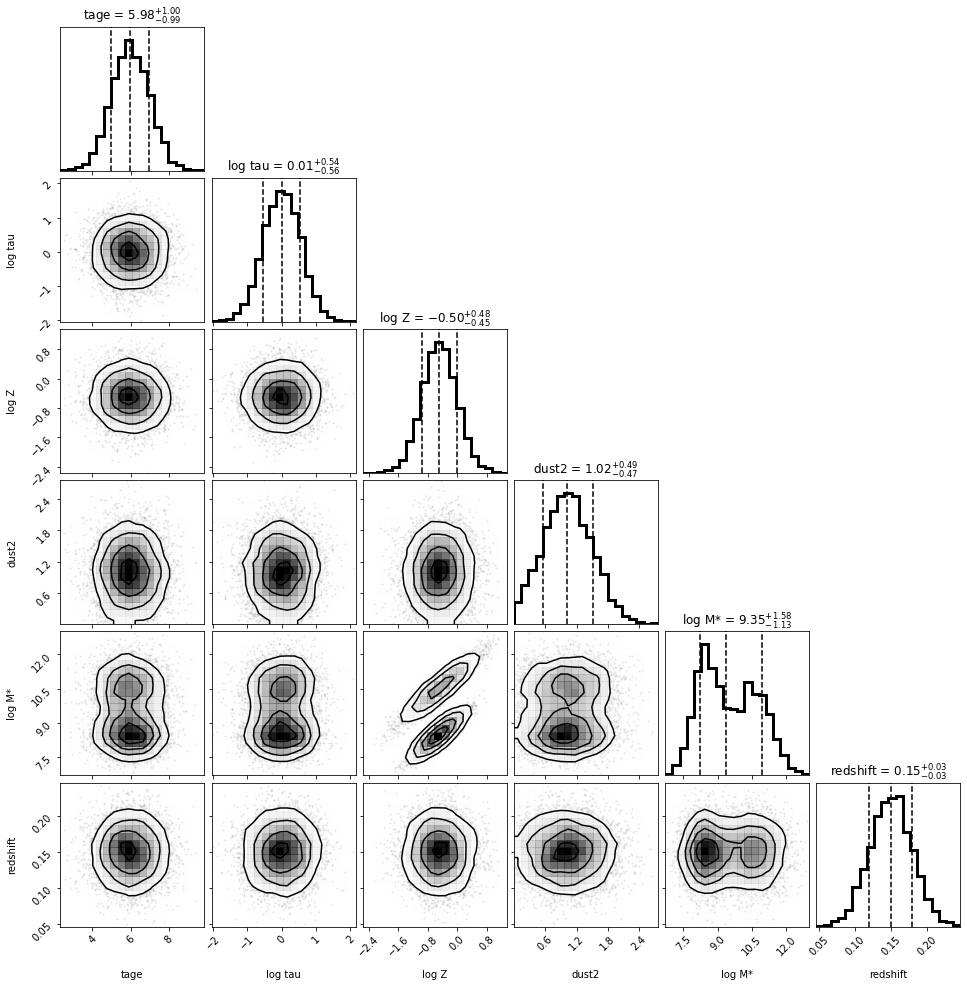

In [9]:
X_data = speculator._predict_mag_with_mass_redshift(
    Y_truth,
    filterset=filters,
    noise=noise, 
    noise_model_dir=noise_model_dir)
flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))
flags = [((Y_truth[:, i] < speculator.bounds[i, 1]) & (Y_truth[:, i] > speculator.bounds[i, 0])).cpu().numpy()
 for i in range(len(speculator.bounds))]
flag = flag.cpu().numpy() & np.array(flags).all(axis=0)

X_data = X_data[flag].detach()
Y_truth = Y_truth[flag]

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift'],
                       smooth=0.7,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

### We try to achieve our goal with loss = Sinkhorn(X, Y), where X is the observed SED, and Y is the model output.

In [114]:
X_train, X_vali, Y_train, Y_vali = train_test_split(X_data, Y_truth, test_size=0.1)

In [139]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss
#del NDE_theta, samples

np.random.seed(42)

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf', num_transforms=10,
                                              num_bins=10, # how smashed it is. 
                                              hidden_features=30, # 120, 
                                              output_dir=None, 
                                              initial_pos={'bounds': [[ 3, 10],
                                                                      [-1.5, 1.5],
                                                                      [-1.5, 1],
                                                                      [0,  2],
                                                                      [7, 11],
                                                                      [0.05, 0.3]], 
                                                           'std':  [1.7, 2, 1, 1, 2, 0.07]
                                                          },
#                                               initial_pos={'mean': [7, 0, -0.5, 1.5, 10, 0.15], 
#                                                           'std':  [1.7, 2, 1, 1, 2, 0.07], 
#                                                            'perturb': [0.3, 0.3, 0.3, 0.3, 0.4, 0.01]
#                                                           },
                                              normalize=False)
NDE_theta.build(
    Y_train,
    X_train,
    filterset=filters,
    optimizer='adam')

NDE_theta.load_validation_data(X_vali, Y_vali)
NDE_theta.bounds = speculator.bounds

[ 8.57580091 -0.94969563  0.4492275   1.19370032  8.78333101  0.07499373]


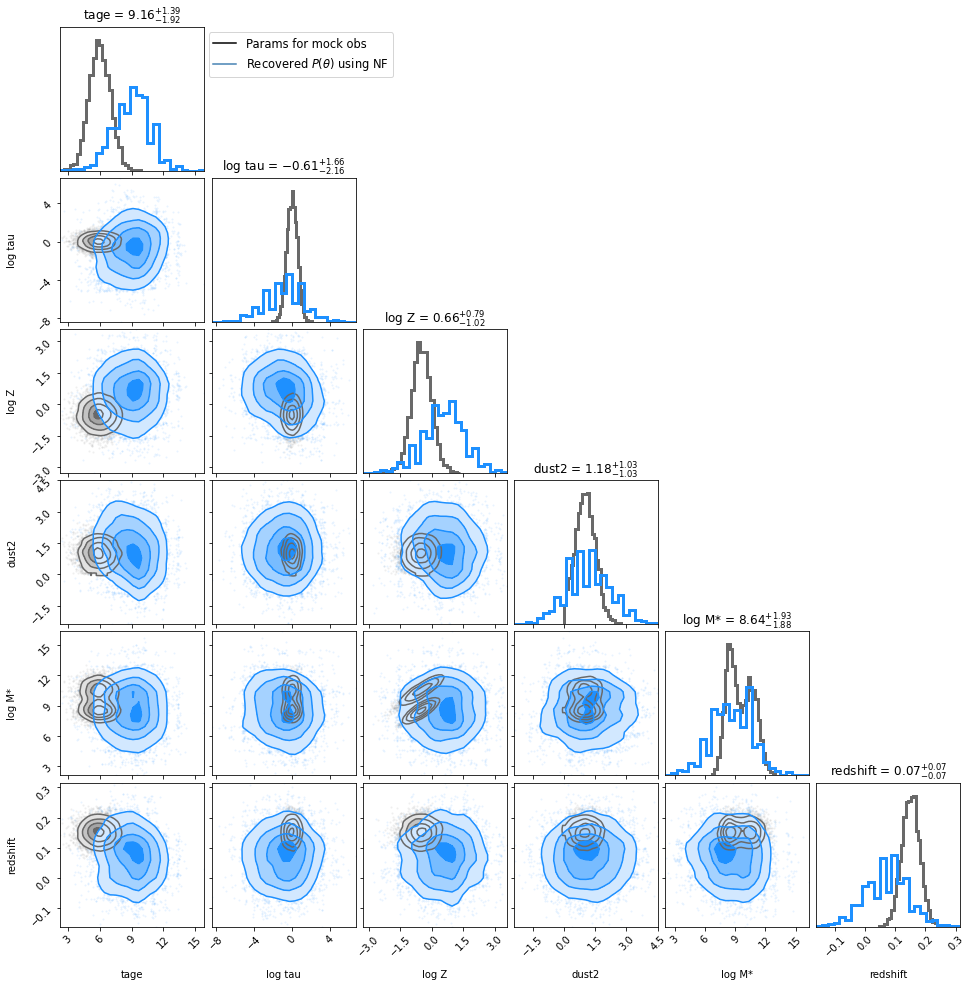

In [140]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [83]:
# _X_train, _ = train_test_split(
#     NDE_theta.X.detach(), test_size=0.3, shuffle=True)
n_samples = len(NDE_theta.X.detach())

L = SamplesLoss(loss="sinkhorn", **{'p': 1, 'blur': 0.1, 'scaling': 0.8})

loss, bad_ratio = NDE_theta._get_loss(NDE_theta.X.detach(), speculator, n_samples,
                                 noise, None, noise_model_dir, L)
loss.backward()
loss, bad_ratio

Bad mask: tensor(1671, device='cuda:0')


(tensor(27.3003, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(25.8665, device='cuda:0', grad_fn=<MeanBackward0>))

In [141]:
max_epochs = 2
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=1e-3, 
                                                steps_per_epoch=100, 
                                                epochs=max_epochs)
for epoch in range(max_epochs):
    print('lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    NDE_theta.train(n_epochs=100,
                speculator=speculator, 
                noise=noise, noise_model_dir=noise_model_dir,
                sinkhorn_kwargs={'p': 1, 'blur': 0.1, 'scaling': 0.8},
                scheduler=scheduler
               )

lr: 3.9999999999999996e-05


Loss = 0.202 (train), 0.130 (bad ratio): 100%|███████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.54epochs/s]


lr: 0.0008028958103403222


Loss = 0.191 (train), 0.137 (bad ratio):  35%|██████████████████████▍                                         | 35/100 [00:14<00:26,  2.44epochs/s]

log spec > 20 params: tensor([[-0.0909,  0.5883, -2.1105,  2.5629,  8.5609,  0.2406]],
       device='cuda:0', grad_fn=<IndexBackward0>)


Loss = 0.061 (train), 0.013 (bad ratio): 100%|███████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45epochs/s]


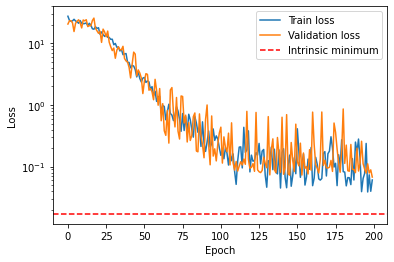

In [143]:
NDE_theta.plot_loss()
plt.yscale('log')

In [99]:
Y = NDE_theta.scaler.transform(
    speculator._predict_mag_with_mass_redshift(
        NDE_theta.sample(2000), filterset=filters)
)
# bad_ratio = (torch.isnan(Y).any(dim=1).sum() +
#              torch.isinf(Y).any(dim=1).sum()) / len(Y)
# val = 20.0
# Y = torch.nan_to_num(Y, val, posinf=val, neginf=-val)
# Y = Y[~(torch.isinf(Y).any(dim=1) | torch.isnan(Y).any(dim=1))]
# Y = torch.nan_to_num(Y, 0.0, posinf=0.0, neginf=-.0)

In [100]:
torch.isnan(Y).any(dim=1).sum()

tensor(0, device='cuda:0')

In [51]:
NDE_theta.sample(2000)

tensor([[ 2.6343,  1.5139,  0.9115,  0.7692,  9.3683,  0.2659],
        [ 3.7405,  2.1012, -0.5623,  0.6141,  7.8895,  0.2525],
        [ 3.2378, -0.6279, -1.5155,  1.7947,  8.7300,  0.2798],
        ...,
        [ 3.8318,  1.7025, -1.0653,  1.8643,  8.7002,  0.2504],
        [ 5.1130, -0.1236, -1.2512,  0.4000,  7.9769,  0.2913],
        [ 3.9086,  0.8091, -1.8617,  0.6460,  9.6945,  0.2483]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [28]:
NDE_theta.train_loss_history[np.argmin(NDE_theta.vali_loss_history)]

0.1665870100259781

In [16]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

Best epoch: 371
Best train loss: 0.014737920835614204
Best vali loss: 0.07552631944417953


In [137]:
NDE_theta.best_model.goodness_of_fit(Y_truth, p=1)
NDE_theta.goodness_of_fit(Y_truth, p=1)

Log10 Wasserstein distance in theta space:  0.4695323896958321
Log10 Wasserstein distance in theta space:  0.4679059614106854


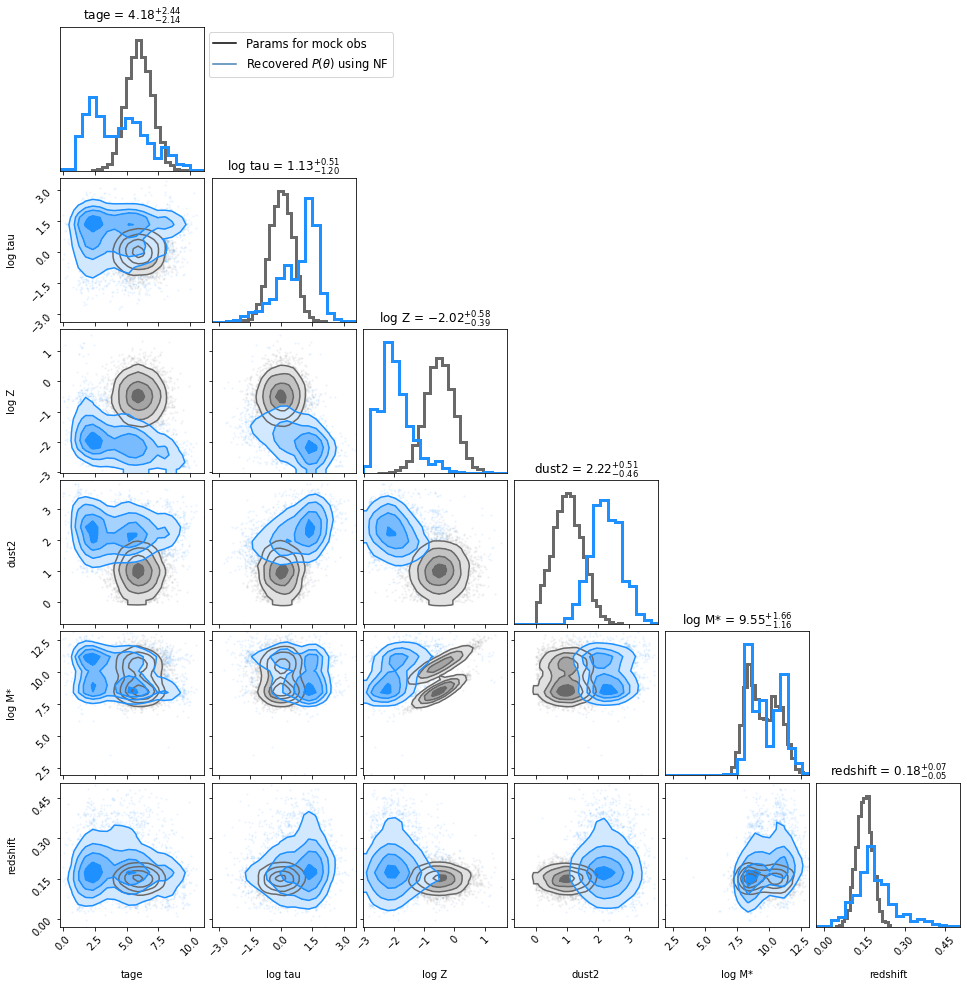

In [138]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=20,
                       #range=[[2.0, 10.0], [-3, 4], [-2, 1], [0, 4], [8, 12], [-0.05, 0.2]],
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.8, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

samples = torch.nan_to_num(samples, 0, posinf=0, neginf=0)
nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=20,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.8, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('With noise')

0 5000


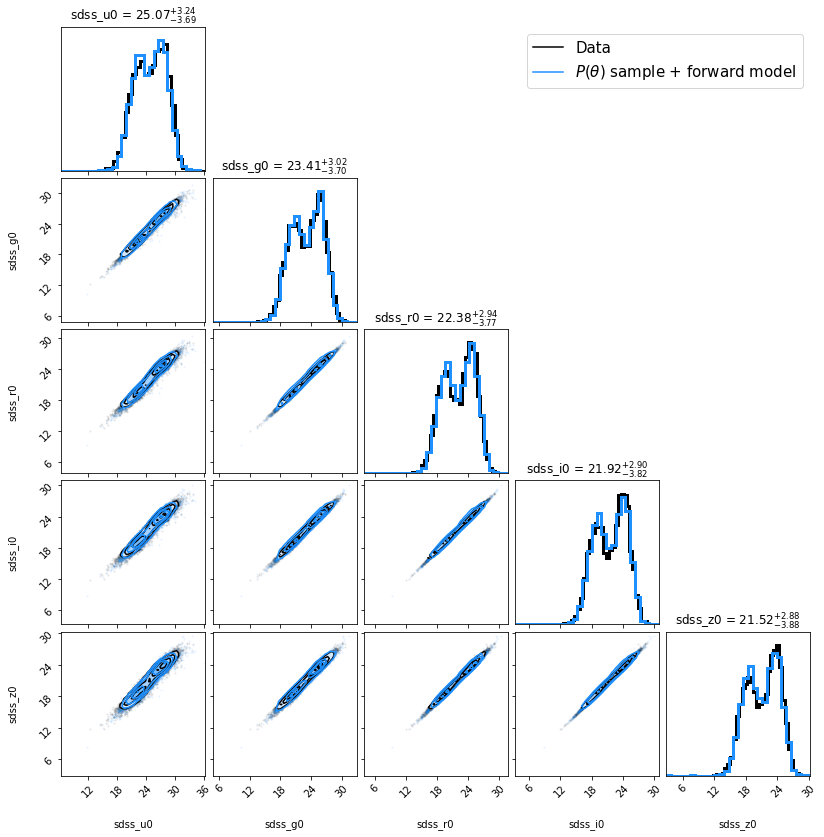

In [105]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = filters

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(samples,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [81]:
Y = speculator._predict_mag_with_mass_redshift(
        NDE_theta.sample(n_samples), filterset=NDE_theta.filterset,
        noise=noise, SNR=None, noise_model_dir=noise_model_dir)

In [79]:
L = SamplesLoss(loss="sinkhorn", p=1, blur=0.1, scaling=0.8)
L(X_data, Y)

tensor(49.8166, device='cuda:0', grad_fn=<SelectBackward0>)

In [209]:
powers = torch.Tensor([200, 200, 200, 200, 200, 1000])
log_prior(NDE_theta.sample(3000),
                    torch.Tensor(speculator.bounds), powers).sum()

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [14]:
from geomloss import SamplesLoss

In [15]:
Y = speculator._predict_mag_with_mass_redshift(samples,
                                               noise=noise,
                                               noise_model_dir=noise_model_dir,
                                                  )
bad_mask = (torch.isnan(Y).any(dim=1) | torch.isinf(Y).any(dim=1))
bad_ratio = bad_mask.sum() / len(Y)
Y = Y[~bad_mask]

In [21]:
with open('./umap_mags.pkl', 'rb') as f:
    reducer = pickle.load(f)

In [68]:
embedding_Y = reducer.transform(Y.cpu().detach().numpy())
embedding_X = reducer.transform(X_train.cpu().detach().numpy())

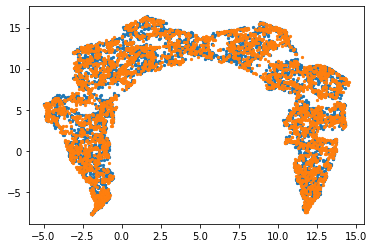

In [70]:
plt.scatter(embedding_Y[:, 0], embedding_Y[:, 1], s=5)
plt.scatter(embedding_X[:, 0], embedding_X[:, 1], s=5)

In [70]:
L = SamplesLoss(loss="sinkhorn", p=1, blur=0.1, scaling=0.8)
L(NDE_theta.X, Y)

In [158]:
torch.log10(L(NDE_theta.X, Y))

tensor(-1.5337, device='cuda:0', grad_fn=<SubBackward0>)

### Fuzzy logic?
$y = \log\left(\frac{1}{1 + |x / a|^{2b}}\right)$

In [424]:
bounds = np.array([[0, 14], [-3, 3], [-3, 2], [0, 4], [0, 16], [0, 10]])
powers = np.array([200, 200, 200, 200, 200, 1000])

In [99]:
# numpy version
def fuzzy_logic_prior(x, loc, width, power):
    return -100 * np.log10(1 / (1 + np.abs((x - loc) / width)**(power)))

def log_prior(theta, bounds, powers):
    width = (bounds[:, 1] - bounds[:, 0]) / 2
    loc = (bounds[:, 1] + bounds[:, 0]) / 2

    return np.sum([fuzzy_logic_prior(theta[i], loc[i], 10 ** (3
                  / powers[i]) * width[i], powers[i]) for i in
                  range(len(bounds))])

In [93]:
def fuzzy_logic_prior(x, loc, width, power):
    return -100 * torch.log10(1 / (1 + torch.abs((x - loc) / width)**(power)))

def log_prior(theta, bounds, powers):
    width = (bounds[:, 1] - bounds[:, 0]) / 2
    loc = (bounds[:, 1] + bounds[:, 0]) / 2
    print(width, loc)

    return torch.vstack([fuzzy_logic_prior(spl[:, i], loc[i], 10 ** (3
              / powers[i]) * width[i], powers[i]) for i in
              range(len(bounds))]).sum(dim=0)

In [94]:
bounds = torch.Tensor([[0, 14], [-3, 3], [-3, 2], [0, 4], [0, 16], [0, 10]])
powers = torch.Tensor([200, 200, 200, 200, 200, 1000])

In [95]:
log_prior(spl, bounds, powers).mean()

tensor([7.0000, 3.0000, 2.5000, 2.0000, 8.0000, 5.0000]) tensor([ 7.0000,  0.0000, -0.5000,  2.0000,  8.0000,  5.0000])


tensor(52.4393, device='cuda:0', grad_fn=<MeanBackward0>)

$-A * \log(1 - \rm{bad\_frac})$

$5 < log M <12$

$\frac{1}{1 + |x/a|^b}$

In [36]:
def fuzzy_logic_prior(x, loc, width, power):
    return -100 * torch.log10(1 / (1 + torch.abs((x - loc) / width)**(power)))

def log_prior(theta, bounds, powers):
    width = (bounds[:, 1] - bounds[:, 0]) / 2
    loc = (bounds[:, 1] + bounds[:, 0]) / 2

    return torch.vstack([fuzzy_logic_prior(spl[:, i], loc[i], 10 ** (3
              / powers[i]) * width[i], powers[i]) for i in
              range(len(bounds))]).sum(dim=0)

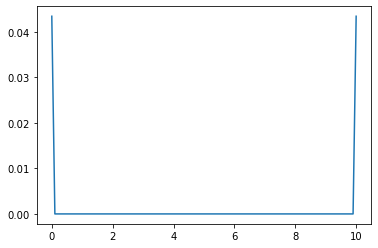

In [238]:
bounds = torch.Tensor([[0, 14], [-3, 3], [-3, 2], [0, 4], [0, 16], [0, 10]])
# powers = torch.Tensor([200, 200, 200, 200, 200, 1000])
# powers = torch.ones((6,)) * 50
powers = torch.Tensor([50, 50, 50, 50, 50, 500])
# spl = NDE_theta.sample(100)

width = (bounds[:, 1] - bounds[:, 0]) / 2
loc = (bounds[:, 1] + bounds[:, 0]) / 2

ind = -1
x = torch.linspace(*bounds[ind], 100)
plt.plot(x, fuzzy_logic_prior(x, loc[ind], 10**(3 / powers[ind]) * width[ind], power=powers[ind]))
# plt.hist(spl[:, ind].detach().cpu().numpy(), histtype='step', density=True)
# plt.xlim(-0.1, 0.1)
# plt.ylim(0, 10)
#plt.axvline(0, c='k')

In [241]:
fuzzy_logic_prior(0.02, loc[ind], 10**(2 / powers[ind]) * width[ind], power=powers[ind])

tensor(0.0585)

In [ ]:
log_prior

In [65]:
spl = NDE_theta.sample(2034)
bounds = torch.Tensor(speculator.bounds).to(NDE_theta.device)
powers = torch.Tensor([50, 50, 50, 50, 50, 500]).to(NDE_theta.device)
# powers = torch.Tensor([200, 200, 200, 200, 200, 1000]).to(NDE_theta.device)

In [68]:
penalty = log_prior(NDE_theta.sample(n_samples),
                    torch.Tensor(speculator.bounds).to(NDE_theta.device), powers)
penalty = penalty[~torch.isinf(penalty)].mean()

In [69]:
penalty

tensor(624.5278, device='cuda:0', grad_fn=<SumBackward0>)

In [45]:
log_prior(spl, bounds, powers).mean()

tensor(20.3492, device='cuda:0', grad_fn=<MeanBackward0>)

In [161]:
spl[torch.isinf(log_prior(spl, bounds, powers))]

tensor([[ 6.1991, -0.6945, -4.7056,  0.9094,  8.0483,  0.1446]],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [152]:
bounds

tensor([[ 0., 14.],
        [-4.,  4.],
        [-3.,  2.],
        [ 0.,  5.],
        [ 0., 16.],
        [ 0., 10.]], device='cuda:0')

In [ ]:
6.1991, -0.6945, -4.7056,  0.9094,  8.0483,  0.1446

In [ ]:
X_train, _ = train_test_split(
    NDE_theta.X.detach(), test_size=0.3, shuffle=True)
n_samples = len(X_train)

L = SamplesLoss(loss="sinkhorn", **{'p': 1, 'blur': 0.1, 'scaling': 0.8})

loss, bad_ratio = NDE_theta._get_loss(X_train, speculator, n_samples,
                                 noise, None, noise_model_dir, L)